Essential tools for data manipulation, modeling, and visualization.

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

We load the dataset and prepare it for modeling by handling missing or inconsistent data.

In [29]:
#Load and preprocess the dataset
df = pd.read_csv("data_3dprinter.csv")
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

#Encode categorical features 
if 'infill_pattern' in df.columns:
    df['infill_pattern'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
if 'material' in df.columns:
    df['material'] = df['material'].map({'abs': 0, 'pla': 1})
df.drop(columns=['material', 'infill_pattern'], errors='ignore', inplace=True)

#Define features and target
X = df.drop(columns=['tensile_strength'])
y = df['tensile_strength']

We isolate our input features and define the output we want the model to predict.
Model is now ready for performance evaluation.

In [19]:
#Evaluation metrics function
def evaluate_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{dataset_name} Set Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

Test various hyperparameter combinations to find the optimal model settings.
This visual checks if predictions align well with actual data.

In [22]:
#Visualization function for predictions
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel("Actual Tensile Strength")
    plt.ylabel("Predicted Tensile Strength")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


Helps explain which features influence predictions and how.
Using the best-found parameters, we train our Decision Tree model.

Highlights how model sensitivity changes across parameter values.

In [16]:
#Grid Search: Best model by RMSE and R2
results = []
for max_depth in range(1, 101):
    for random_state in range(101):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2 = r2_score(y_test, y_test_pred)
        results.append((max_depth, random_state, rmse, r2))

Defines how we measure model accuracy using metrics like RMSE and R².

In [18]:
#Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['MaxDepth', 'RandomState', 'RMSE', 'R2'])

#Best model based on RMSE and R²
best_model = results_df.loc[results_df['RMSE'].idxmin()]
print("\nBest Model Configuration")
print(best_model)


Best Model Configuration
MaxDepth        2.000000
RandomState    73.000000
RMSE            1.670857
R2              0.967325
Name: 174, dtype: float64


Selects the best hyperparameters for the data by looping them from 0 to 100. Here the best hyperparameter for the tree model for tensile strength the optimal random state is 73. With its predicted R^2 value. However the suggested best parameters, especially for the depth need to be further investigated below, with data visualisation. 

A scatter plot to help visually compare predicted and actual values.

In [20]:
#Train final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(best_model['RandomState']))
final_model = DecisionTreeRegressor(max_depth=int(best_model['MaxDepth']))
final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

See how the model makes decisions at each node.


Training Set Evaluation:
MAE: 3.75
MSE: 21.98
RMSE: 4.69
R²: 0.71

Testing Set Evaluation:
MAE: 1.27
MSE: 2.79
RMSE: 1.67
R²: 0.97


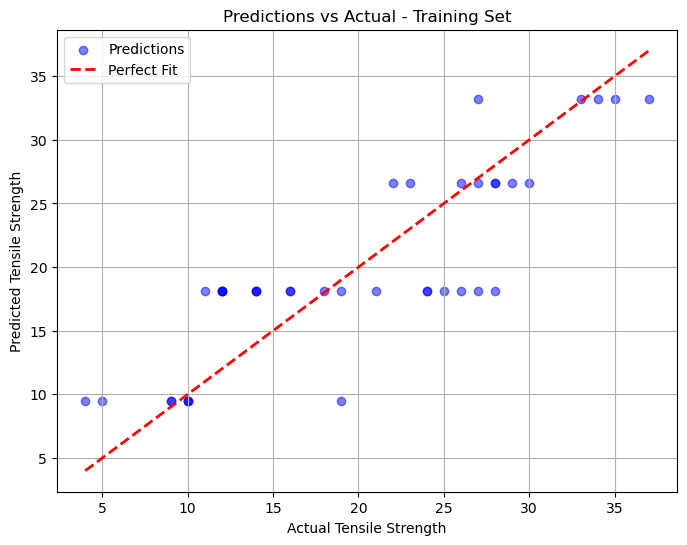

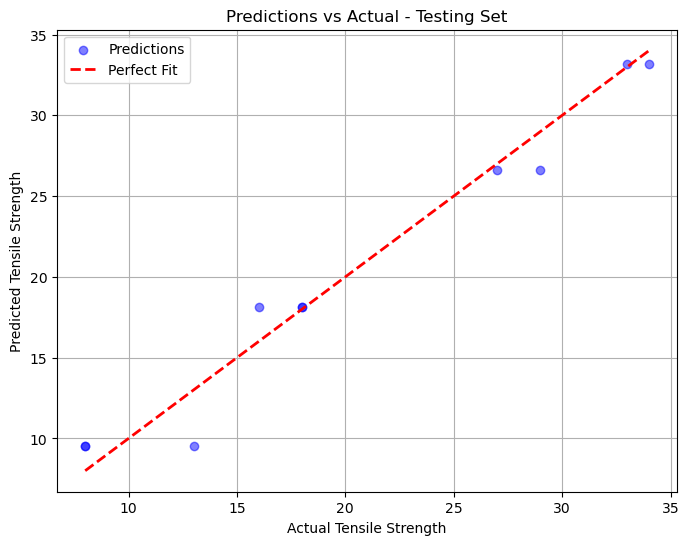

In [22]:
#Evaluate
evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_test, y_test_pred, "Testing")

#Plot predictions
plot_predictions(y_train, y_train_pred, "Predictions vs Actual - Training Set")
plot_predictions(y_test, y_test_pred, "Predictions vs Actual - Testing Set")

Understand model performance across different hyperparameter configurations.

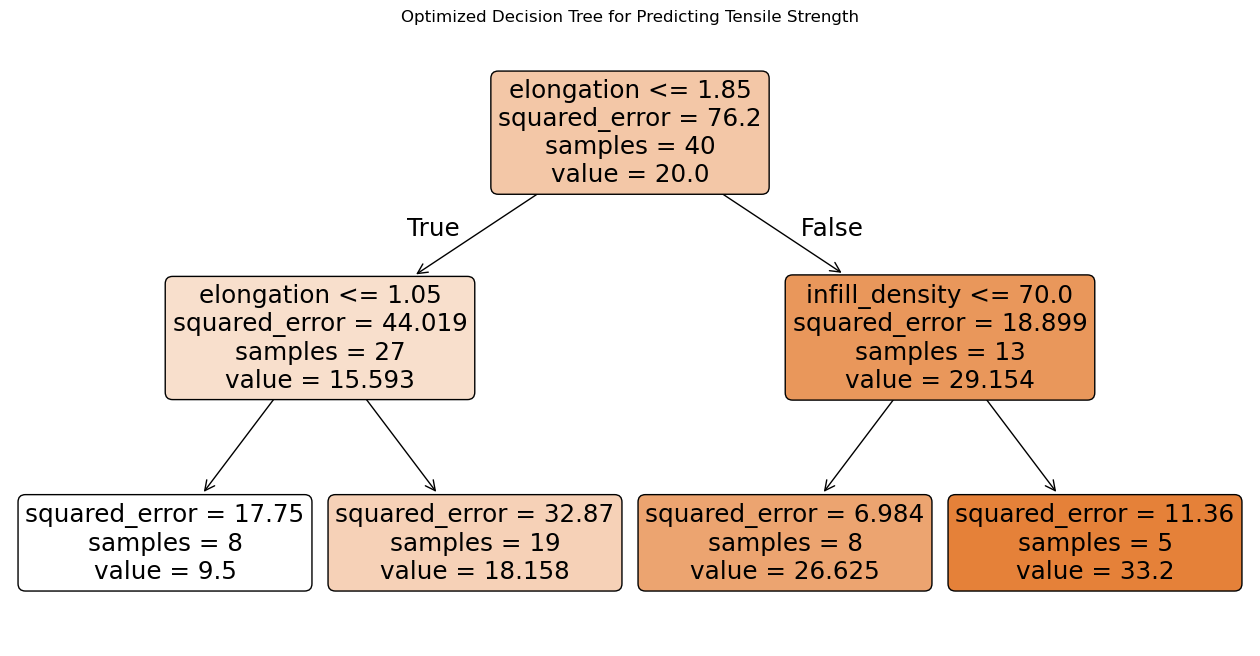

In [24]:
#Visualize decision tree
plt.figure(figsize=(16, 8))
plot_tree(final_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Optimized Decision Tree for Predicting Tensile Strength")
plt.show()

Explore how model depth impacts performance.

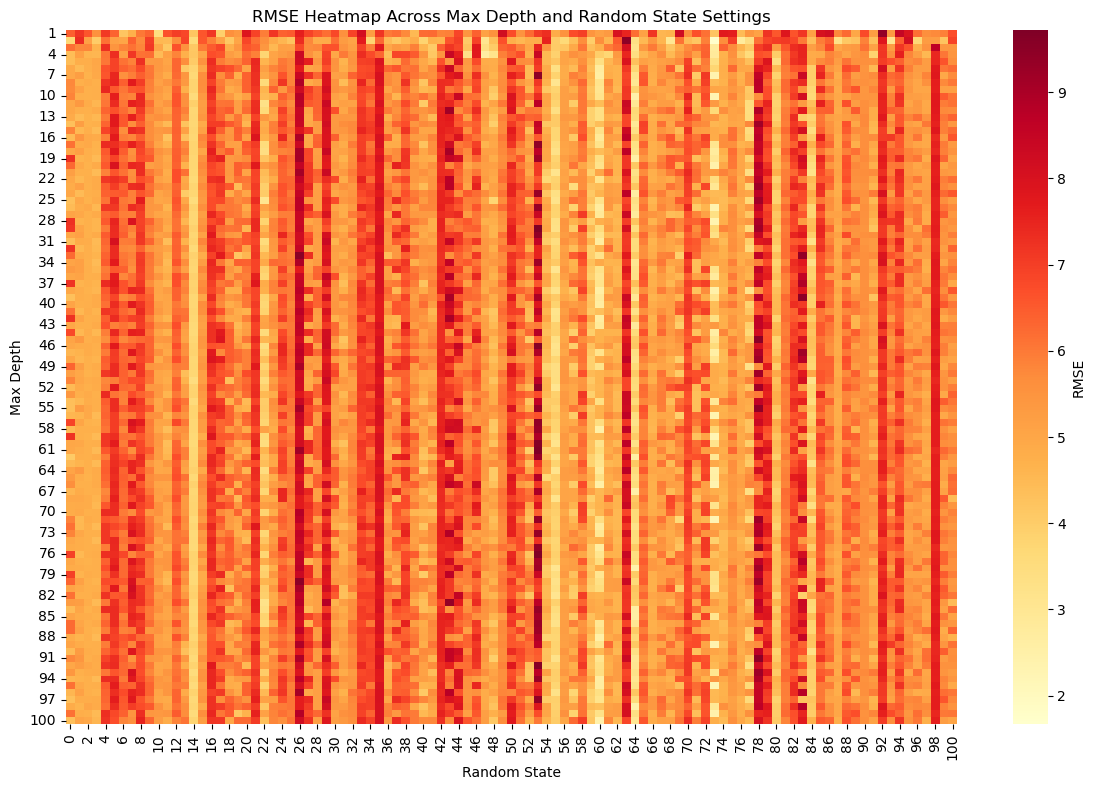

In [26]:
#Heatmap of RMSE
pivot_rmse = results_df.pivot(index='MaxDepth', columns='RandomState', values='RMSE')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rmse, cmap="YlOrRd", cbar_kws={'label': 'RMSE'})
plt.title("RMSE Heatmap Across Max Depth and Random State Settings")
plt.xlabel("Random State")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

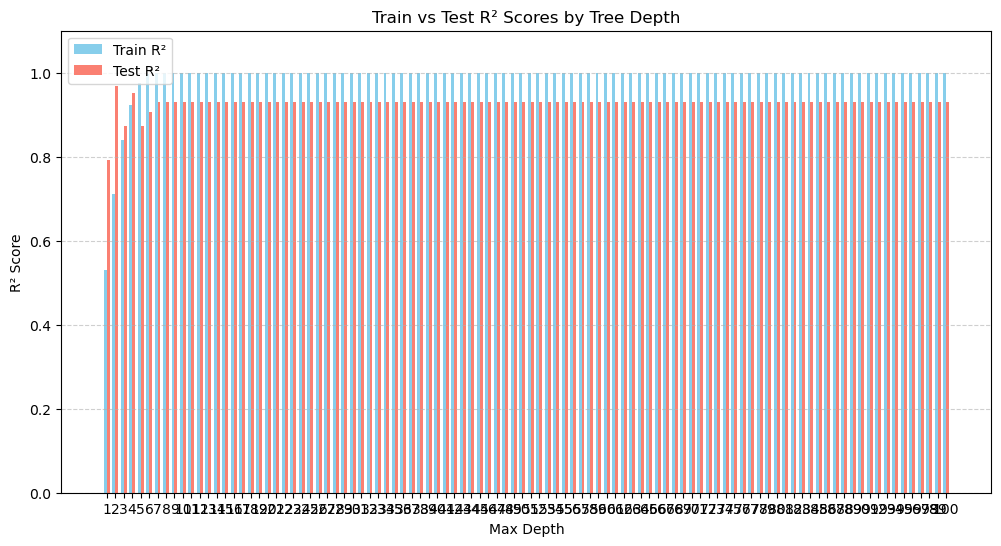

In [27]:
#Define range of depths to test
depths = range(1, 101)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

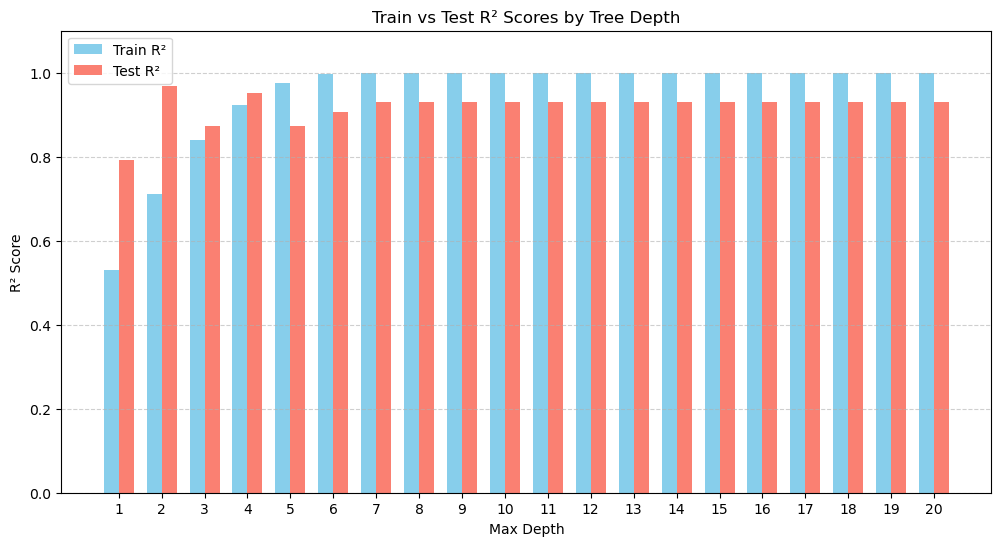

In [28]:
#Define range of depths to test
depths = range(1, 21)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Use the best parameters found earlier to build the final model.

The bar chart presents the performance of a Decision Tree Regressor across varying tree depths from 1 to 100, showing both training and testing R² scores. The training R² score increases progressively from depth 1 and reaches a perfect score of 1.00 at depth 6. From depth 6 onward, the training R² remains consistently at 1.00, indicating that the model is fully memorizing the training data. This suggests the presence of overfitting, as a perfect fit on training data typically implies that the model may not generalize well.

Hence, depths from 1 to 20 has been chosen since approximately this point test R² remains unchanged.

The testing R² score behaves differently. It increases quickly in the early depths and reaches its highest point at depth 2, which is unusually early compared to typical patterns. After this peak, the test R² begins to decline slightly as the tree becomes deeper. From around depth 5 onward, the test R² stabilizes but stays lower than its peak at shallow depth. This decline despite continued gains in training performance signals overfitting, where the model complexity increases but predictive performance on unseen data does not improve and may slightly worsen.

In summary, while the model achieves perfect training performance at depth 6 and beyond, its ability to generalize to test data peaks early and declines with increased depth. This indicates that the optimal tree depth lies around depth 3 to 4 this dataset, and deeper trees may reduce generalization due to overfitting.And trees with depth of 1 and 2 show clear signs of underfitting. Hence, 
The best Max Depths is 4 since it has the lowest difference between train and test R² without big overfitting.

In [31]:
#Use the best random_state identified earlier
best_random_state = int(best_model['RandomState'])

#Train model with max_depth = 4
model_depth_4 = DecisionTreeRegressor(max_depth=4, random_state=best_random_state)
model_depth_4.fit(X_train, y_train)

#Make predictions
y_train_pred = model_depth_4.predict(X_train)
y_test_pred = model_depth_4.predict(X_test)

#Calculate R²
r2_train_depth_4 = r2_score(y_train, y_train_pred)
r2_test_depth_4 = r2_score(y_test, y_test_pred)

#Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

#Display results
print(f"Train R² (Depth 4): {r2_train_depth_4:.4f}")
print(f"Test R²  (Depth 4): {r2_test_depth_4:.4f}")
print(f"Train MAE         : {mae_train:.4f}")
print(f"Test MAE          : {mae_test:.4f}")
print(f"Train RMSE        : {rmse_train:.4f}")
print(f"Test RMSE         : {rmse_test:.4f}")


Train R² (Depth 4): 0.9237
Test R²  (Depth 4): 0.9512
Train MAE         : 1.6167
Test MAE          : 1.6667
Train RMSE        : 2.4109
Test RMSE         : 2.0426


The parameters of the best model with the depth of 4 can be seen on the above. It shows quite high correlation for both training and testing sets of data, as well as lower MAE errors. Suggesting that the model is a good fit for the target. 